#### Objective train EMNIST:
- Images are 2-D -> convert to 3D -> (samples,28,28)
- Lower case only considered where chars are fundamentally different from upper case char
- According to: https://www.tensorflow.org/datasets/catalog/emnist
    - Images: rotated 90 deg ccw
    - horizontal flip
- We want to:
    - Images: rotate 90 deg cw
    - horizontal flip
- No augmentation needed, we have plenty of data

#### Look into/implement for augmentation:
    - Gauss Blur
    - ROI detection
    - Center Frame

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns

In [40]:
train_df = pd.read_csv("emnist-letters-train.csv")
test_df = pd.read_csv("emnist-letters-test.csv")

In [74]:
train_X_df,train_Y_df = train_df.iloc[:,1:],train_df.iloc[:,0]
test_X_df,test_Y_df = test_df.iloc[:,1:],test_df.iloc[:,0]

train_X = train_X_df.to_numpy(dtype = np.float32)
train_Y = train_Y_df.to_numpy(dtype = np.int32)

test_X = test_X_df.to_numpy(dtype = np.float32) 
test_Y = test_Y_df.to_numpy(dtype = np.int32)

train_Y = np.add(train_Y,-1.0)
test_Y = np.add(test_Y,-1.0)

print(train_X.shape,train_Y.shape)
print(test_X.shape,test_Y.shape)

(88799, 784) (88799,)
(14799, 784) (14799,)


In [84]:
label_maps = pd.read_csv("emnist-letters-mapping.txt",header = None,delimiter =" ",index_col = 0,squeeze =True)
label_maps = label_maps.iloc[:,0]
classes = list(range(len(label_maps)))
ascii_chars = [chr(c) for c in label_maps]
label_dict = dict(zip(classes,ascii_chars))
print(label_dict)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


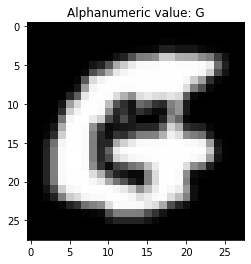

In [85]:
# simple visualization
train_ex = train_X[0].reshape((28,28))
rot = cv2.rotate(train_ex, cv2.ROTATE_90_CLOCKWISE) 
flip = cv2.flip(rot, 1)
train_ex_l = train_Y[0]
plt.title("Alphanumeric value: "+label_dict[train_ex_l])
plt.imshow(flip,cmap="gray")

In [86]:
# preprocess
def preprocess(data):
    new_data = []
    for im in data:
        reshape_im = im.reshape((28,28))
        rot_im = cv2.rotate(reshape_im, cv2.ROTATE_90_CLOCKWISE) 
        flip_im = cv2.flip(rot_im, 1)
        flip_im = flip_im.astype("float32")
        flip_im /= 255.0
        flip_im = flip_im.reshape(28,28,1)
        new_data.append(flip_im)
    new_data = np.array(new_data)
    return new_data

In [87]:
trans_train_X = preprocess(train_X)
trans_test_X = preprocess(test_X)
print(trans_train_X.shape)
print(trans_test_X.shape)

(88799, 28, 28, 1)
(14799, 28, 28, 1)


(28, 28, 1)


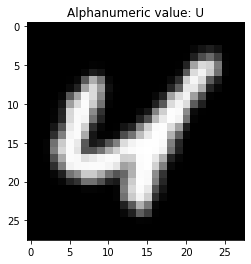

In [88]:
train_ex2 = trans_train_X[12]
print(train_ex2.shape)
train_ex2_l = train_Y[12]
plt.title("Alphanumeric value: "+label_dict[train_ex2_l])
plt.imshow(train_ex2[:,:,0],cmap="gray")

In [90]:
print(train_Y.shape,test_Y.shape)

from keras.utils import to_categorical
oh_train_Y = to_categorical(train_Y,num_classes = 26)
oh_test_Y = to_categorical(test_Y,num_classes = 26)

#should get 47 classes
print(oh_train_Y.shape,oh_test_Y.shape)

(88799,) (14799,)
(88799, 26) (14799, 26)


In [289]:
# training
from tensorflow.keras import layers, models, losses,optimizers,preprocessing,regularizers
def CNN():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(26,activation = "softmax"))
    return model

In [290]:
model = CNN()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               2769408   
_________________________________________________________________
dense_16 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_17 (Dense)             (None, 26)                3354      
Total params: 2,838,746
Trainable params: 2,838,746
Non-trainable params: 0
____________________________________________

In [291]:
optimizer = optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer=optimizer,
              loss= losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(trans_train_X, oh_train_Y, epochs=10, 
                    validation_split = 0.2)


Train on 71039 samples, validate on 17760 samples
Epoch 1/10
71039/71039 [==============================] - 11s 151us/sample - loss: 0.9217 - accuracy: 0.7351 - val_loss: 0.5479 - val_accuracy: 0.8365
Epoch 2/10
71039/71039 [==============================] - 11s 159us/sample - loss: 0.4457 - accuracy: 0.8619 - val_loss: 0.3893 - val_accuracy: 0.8810
Epoch 3/10
71039/71039 [==============================] - 11s 154us/sample - loss: 0.3330 - accuracy: 0.8931 - val_loss: 0.3367 - val_accuracy: 0.8951
Epoch 4/10
71039/71039 [==============================] - 11s 156us/sample - loss: 0.2775 - accuracy: 0.9093 - val_loss: 0.2942 - val_accuracy: 0.9072
Epoch 5/10
71039/71039 [==============================] - 11s 154us/sample - loss: 0.2410 - accuracy: 0.9200 - val_loss: 0.2895 - val_accuracy: 0.9095
Epoch 6/10
71039/71039 [==============================] - 11s 152us/sample - loss: 0.2138 - accuracy: 0.9279 - val_loss: 0.2804 - val_accuracy: 0.9102
Epoch 7/10
71039/71039 [====================

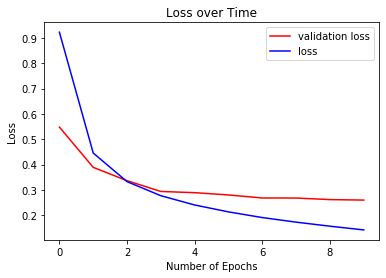

In [292]:
plt.plot(history.history['val_loss'], color='R', label="validation loss")
plt.plot(history.history['loss'], color='B', label="loss")
plt.title("Loss over Time")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

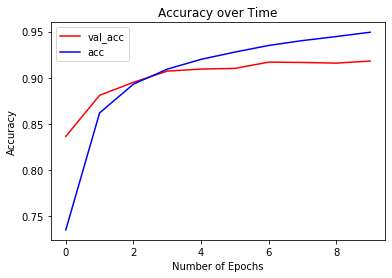

In [293]:
plt.plot(history.history['val_accuracy'], color='R', label="val_acc")
plt.plot(history.history['accuracy'], color='B', label="acc")
plt.title("Accuracy over Time")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [294]:
model.evaluate(trans_test_X,oh_test_Y,verbose = 0)

[0.2919269040515414, 0.905399]

0 0 186 213
(213, 186, 3)


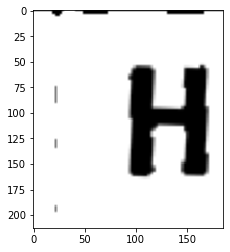

In [437]:
# test on example
random_ex = cv2.imread("h.png")

#resized = cv2.resize(random_ex,(28,28))

gs = cv2.cvtColor(random_ex, cv2.COLOR_BGR2GRAY)
#p = cv2.bitwise_not(gs)
#edged = cv2.Canny(gs, 10, 250)
kernel = np.ones((2,2), np.uint8) 
img_erosion = cv2.dilate(gs, kernel, iterations=1) 
r,c = cv2.findContours(img_erosion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#print(r)
idx = 0
for c in r:
    x,y,w,h = cv2.boundingRect(c)
    if w >= 100 and h >= 75:
        print(x,y,w,h)
        new_img=img_erosion[y:y+h,x:x+w]
new_img = cv2.GaussianBlur(new_img,(3,3),0) 
print(random_ex.shape)

plt.imshow(new_img,cmap="gray")
#import os
#cv2.imwrite(os.getcwd()+'Test_gray.jpg', new_img) 


In [442]:

def preprocess_pipeline(img_batch):
    processed_batch = []
    for im in img_batch:
        gs = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        kernel = np.ones((8,8), np.uint8) 
        img_erosion = cv2.dilate(gs, kernel, iterations=1) 
        resized = cv2.resize(img_erosion,(28,28))
        inversion = cv2.bitwise_not(resized)
        processed = np.array(inversion.reshape((28,28,1)),dtype= np.float32)
        processed /= 255.0
        processed_batch.append(processed)
    return np.array(processed_batch,dtype = np.float32)

(1, 28, 28, 1)


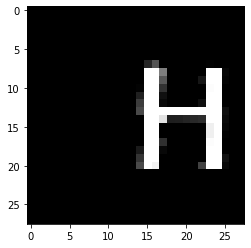

In [443]:
#new_img = cv2.cvtColor(new_img, cv2.COLOR_GRAY2BGR)
ex_test_batch = preprocess_pipeline([random_ex])
#ex_test_label = np.array([1 if i % 17 == 0 else 0 for i in range(1,48)],dtype = float32)
print(ex_test_batch.shape)
plt.imshow(ex_test_batch[0,:,:,0],cmap="gray")

In [441]:
p = model.predict_classes([ex_test_batch])
print(label_dict[p[0]])

M


In [418]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
#q = ex_test_batch[0]
#q = cv2.cvtColor(q, cv2.COLOR_GRAY2BGR)
p = cv2.imread("htes.png")
e = pytesseract.image_to_string(p,config ="--psm 10")
print(e)

H



In [353]:
model.save('emnist.h5')